In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import scipy as sp
from skimage.io import imread
from matplotlib_scalebar.scalebar import ScaleBar
from constants import PIXEL_TO_UM, SAMPLES
from st_utils import correct_tissue_names,name_parser

wd = os.getcwd()
print (f'working directory: {wd}')


def load(sample): # Load gene level data and tag with core metadata
    # Core information: including tissue_type, tumor ...
    csv_sample_info = f"{wd}/data/Sample_Info_{name_parser(sample)['tma'].upper()}_TMA - Sheet1.csv"
    df_core = pd.read_csv(csv_sample_info)[['core','tissue_type']]
    df_core = correct_tissue_names(sample,df_core)
    df_core['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)

    # Rachel curated gene list
    gene_list = pd.read_csv(f"{wd}/data/gene_lists/{name_parser(sample)['platform']}_{name_parser(sample)['panel']}.csv").columns.to_list()

    # Core x gene
    df_t = pd.read_csv(f'{wd}/data/gene_level_csv/gene_level_csv_{sample}.csv')
    df_t = correct_tissue_names(sample,df_t)
    df_t['core'] += (300 if 'tumor2' in sample else 0) + (200 if 'normal' in sample else 0)

    return df_t, df_core, gene_list


working directory: /Users/whuan/dev/ist_benchmarking


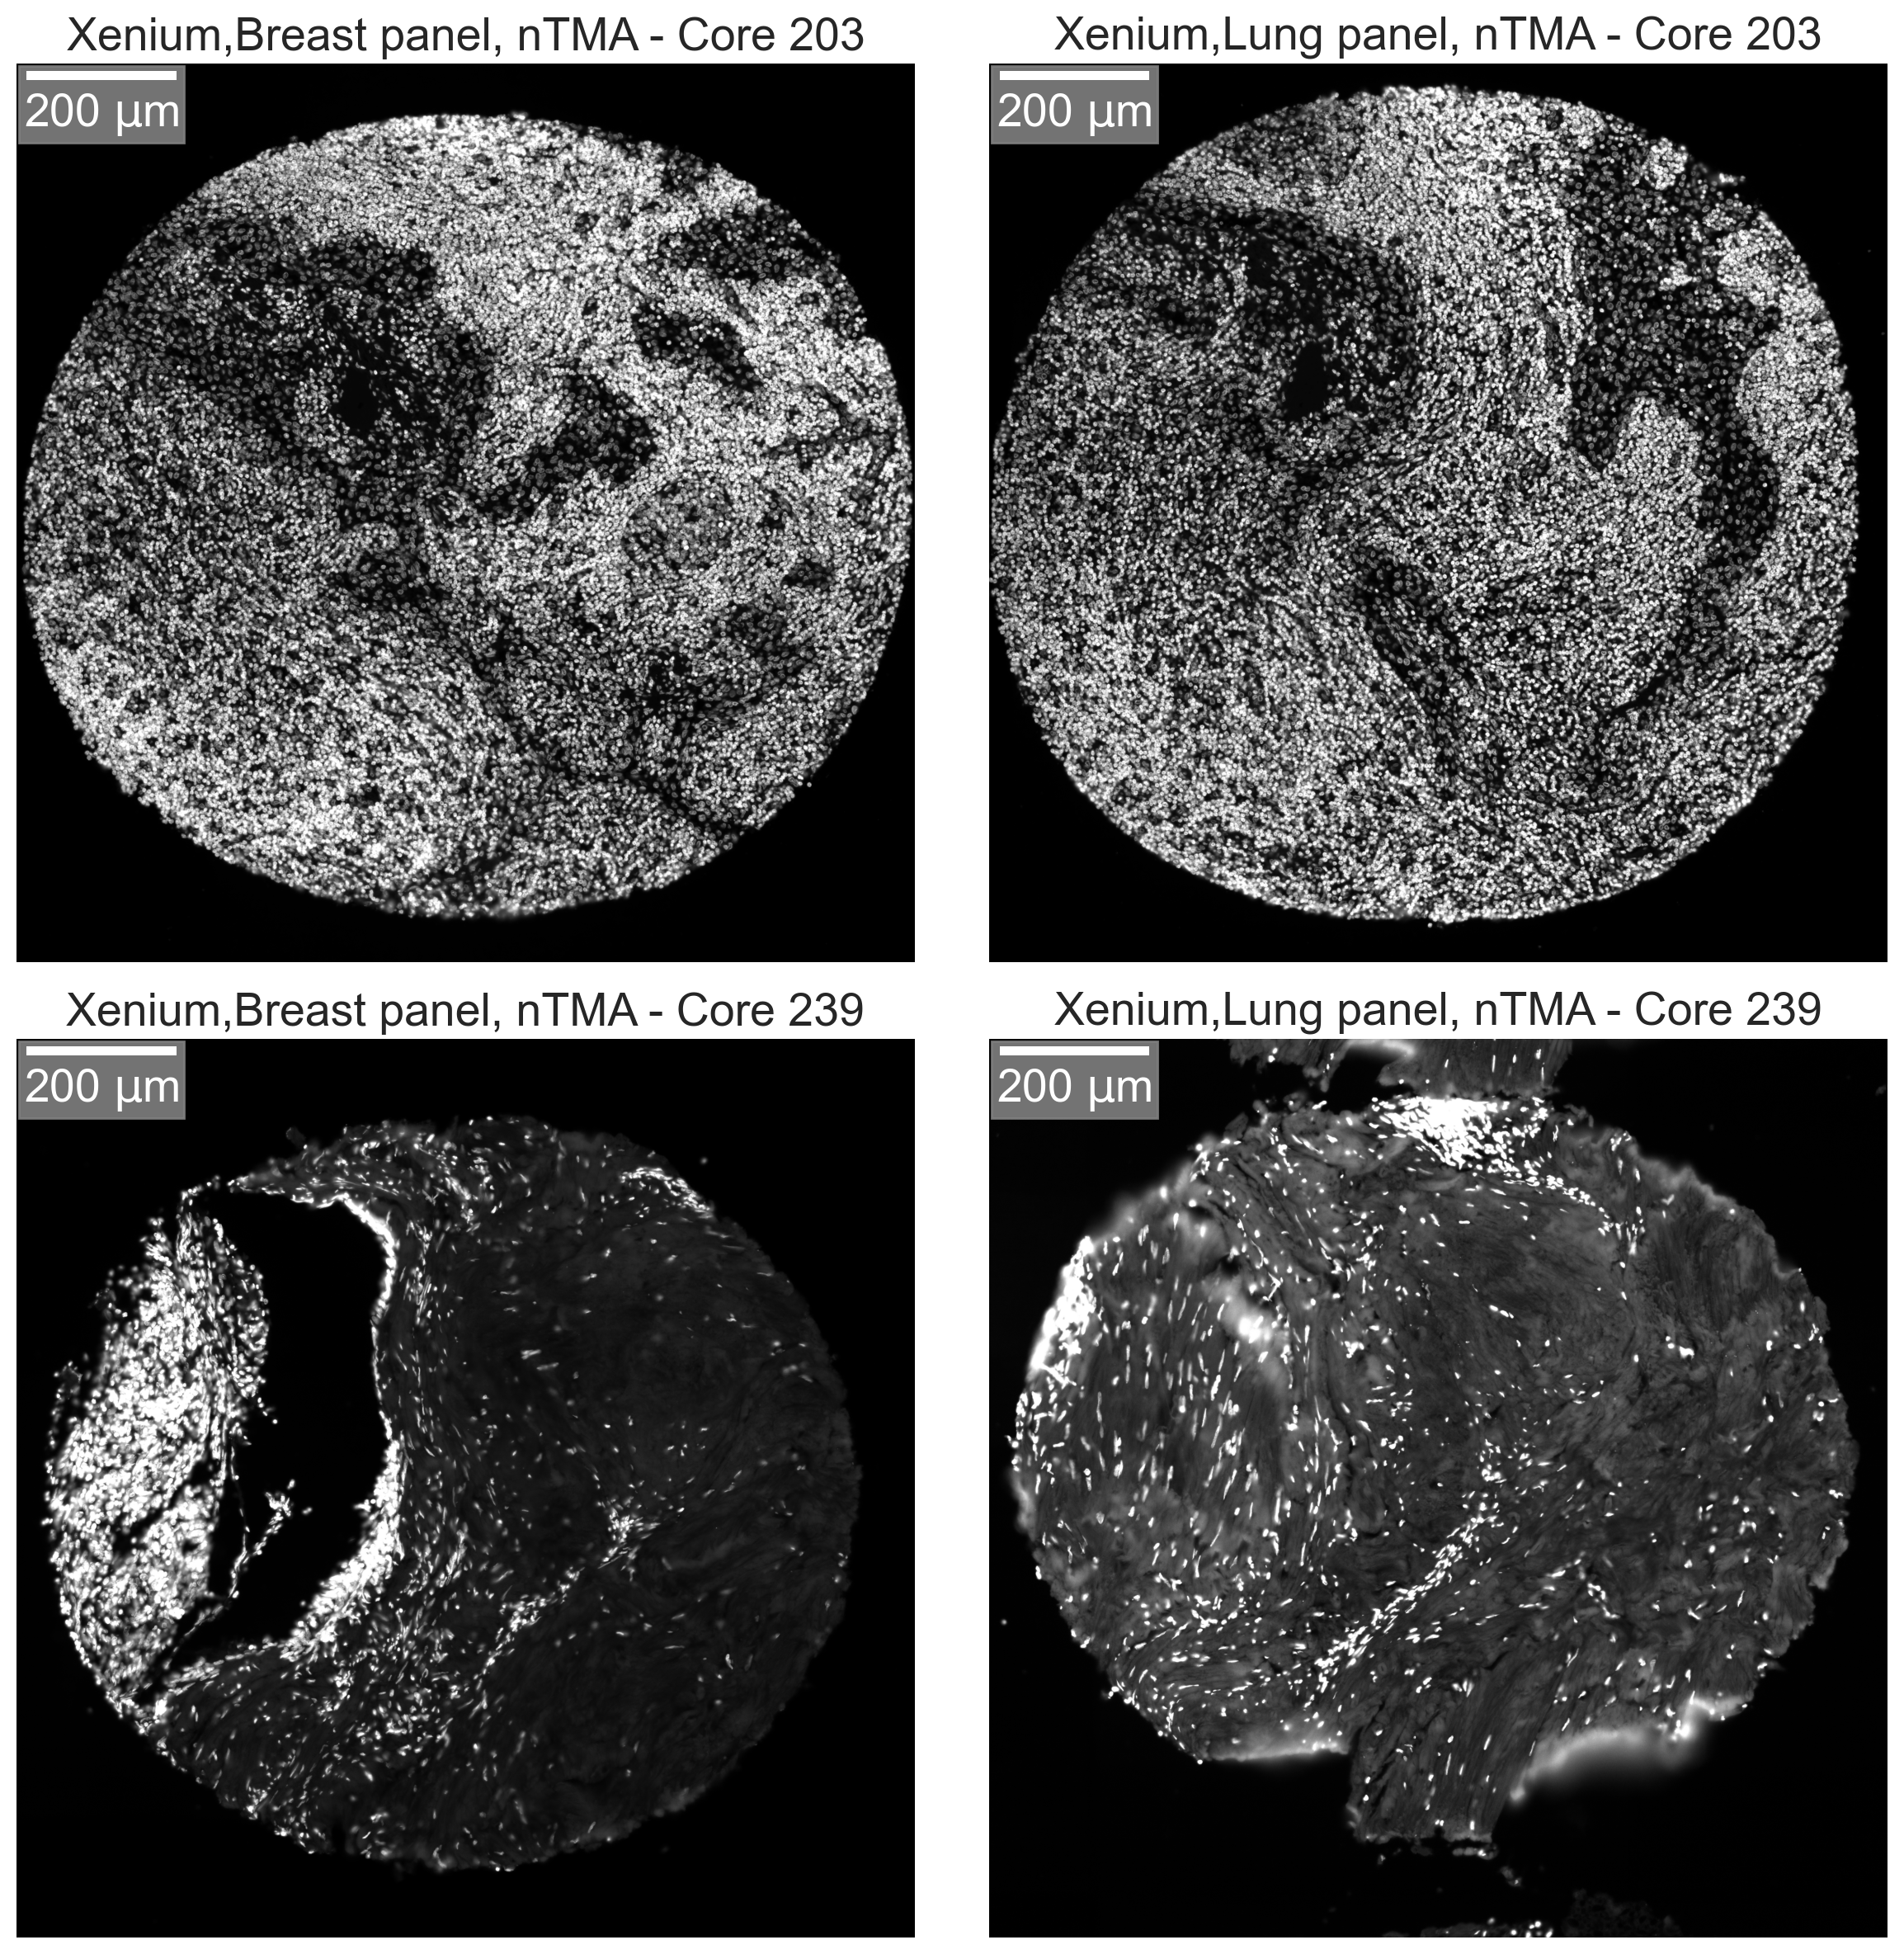

In [51]:
# Define figure width and samples
figwidth = 6
samples = ['xenium_breast_normal', 'xenium_lung_normal']
cores = [3, 39]

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(figwidth * 2, figwidth * 2))

# Loop through samples and cores
for i, core in enumerate(cores):
    for j, sample in enumerate(samples):
        ax = axes[i, j]  # Select appropriate subplot

        # Load image
        fname = f"{wd}/data/{sample}/dapi_by_core/{core}.tif"
        img_dapi = imread(fname)

        # Create scale bar
        scale_bar = ScaleBar(PIXEL_TO_UM[sample.split('_')[0]], "um", 
                             color='white', box_color='grey', box_alpha=0.9, 
                             location='upper left', font_properties={'size': 20})


        label = {
            'xenium_breast_normal':'Xenium,Breast panel, nTMA',
            'xenium_lung_normal':'Xenium,Lung panel, nTMA'
            }[sample]
        # Plot image
        ax.imshow(img_dapi, vmin=np.quantile(img_dapi, 0.02), vmax=np.quantile(img_dapi, 0.98), cmap='gray')
        ax.add_artist(scale_bar)
        ax.set_title(f"{label} - Core {200+core}", fontsize=20)
        ax.axis("off")  # Hide axis

# Adjust layout and show figure
plt.tight_layout()
fname = f"{wd}/figures/response_letter/morphology_impact.png"
fig.savefig(fname, format='png', dpi=200, bbox_inches='tight', transparent=True)
plt.show()


# Panel to panel reproducibity

In [47]:

df_t_all = {}

samples = [sample for sample in SAMPLES[:12]]

for sample in samples:
    print (f'sample: {sample}')
    df_t, df_core, gene_list = load(sample)
    df_t_all[sample] = df_t

df_all = {}

Platform_Panels =  ['Xenium,breast',
                    'Xenium,multi-tissue',
                    'Xenium,lung',
                    'MERSCOPE,breast',
                    'MERSCOPE,lung',
                    'CosMx,1k']

for i in range(0,6):
    df_all[Platform_Panels[i]] = pd.DataFrame()
    df_htma = df_t_all[samples[2*i]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_htma])
    df_normal = df_t_all[samples[2*i+1]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_normal])

sample: xenium_breast_htma
sample: xenium_breast_normal
sample: xenium_panhuman_htma
sample: xenium_panhuman_normal
sample: xenium_lung_htma
sample: xenium_lung_normal
sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_lung_htma
sample: merscope_lung_normal
sample: cosmx_multitissue_htma
sample: cosmx_multitissue_normal


## Including unmacted cores

Xenium,breast vs. Xenium,multi-tissue


1.09

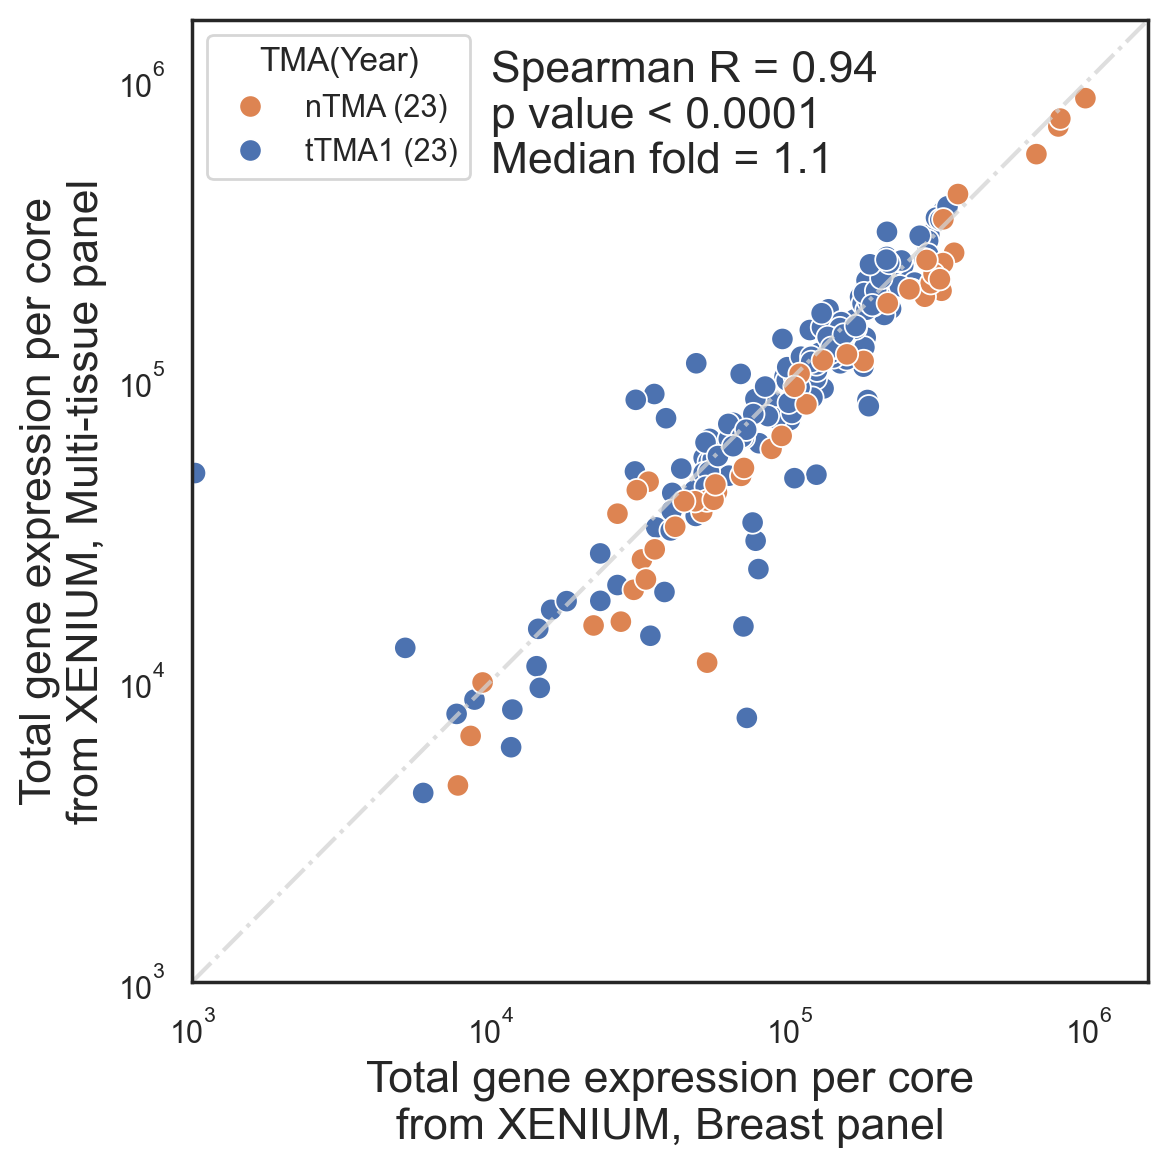

Xenium,breast vs. Xenium,lung


1.28

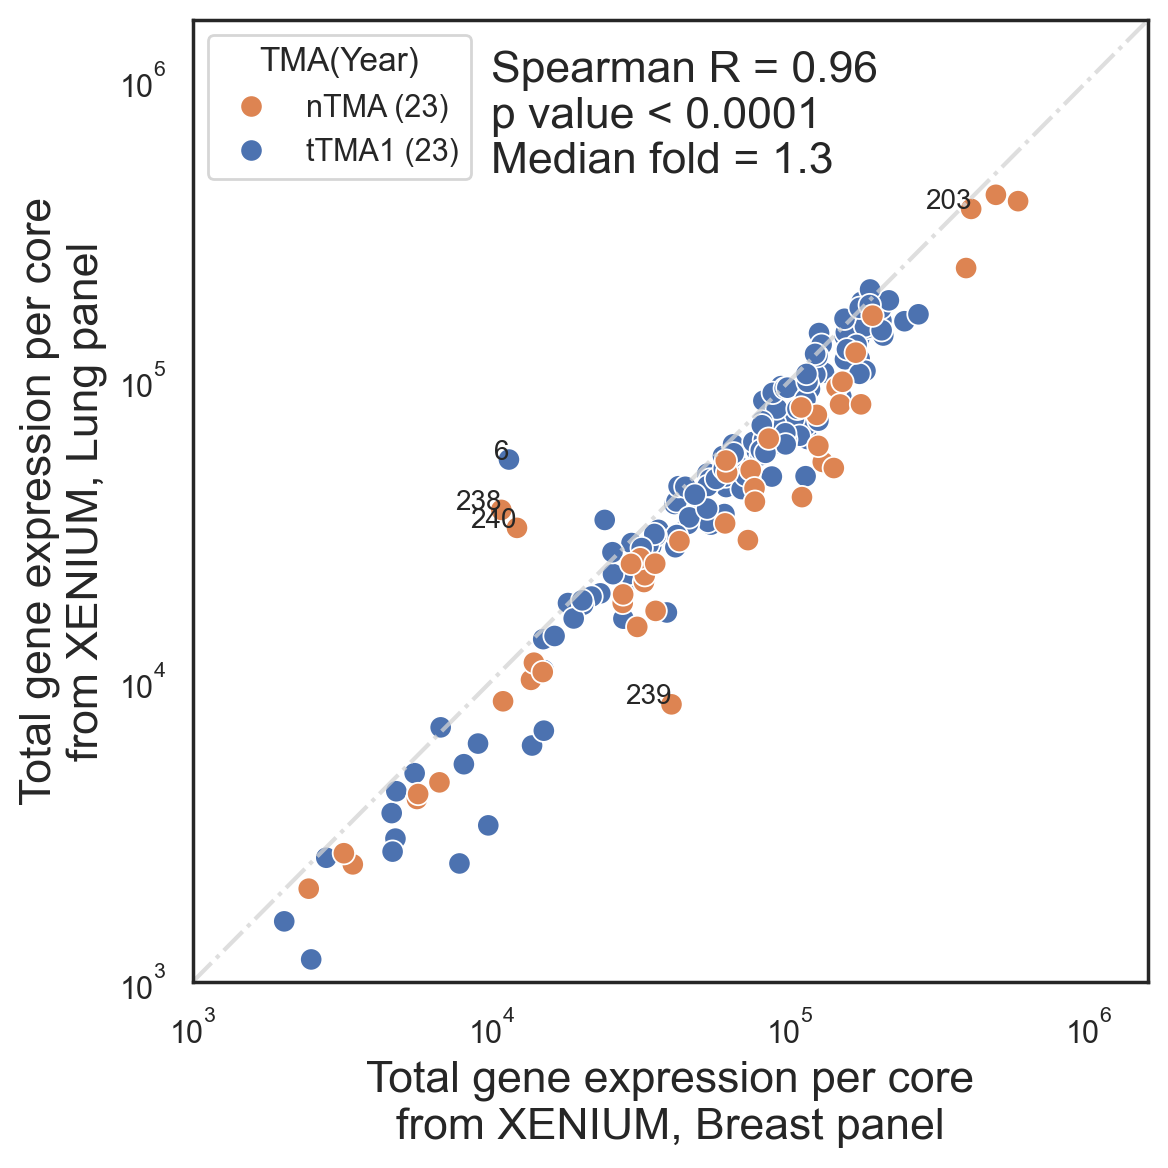

MERSCOPE,breast vs. MERSCOPE,lung


3.3

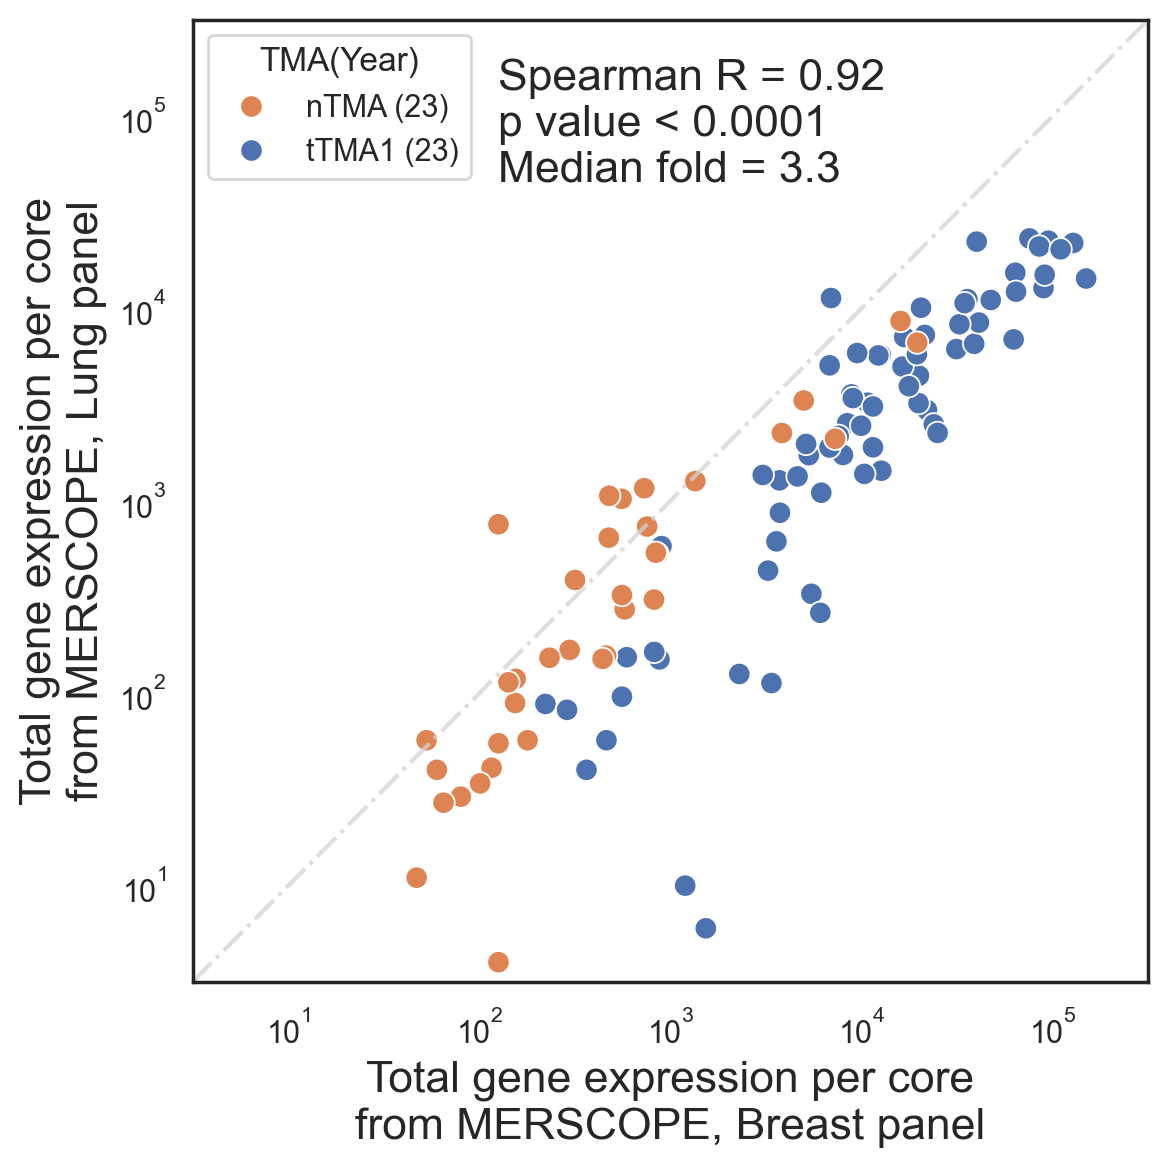

In [48]:


if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

fontsize = 16

for Platform_Panel_pair in [
    (Platform_Panels[0], Platform_Panels[1]),  # panel to panel, xenium
    (Platform_Panels[0], Platform_Panels[2]),  # panel to panel, xenium
    (Platform_Panels[3], Platform_Panels[4])   # panel to panel, merscope
]:
    sample1 = Platform_Panel_pair[0]    
    df_1 = df_all[sample1].rename(columns={'count': sample1})
    df_1 = df_1.loc[df_1['code_type'] == 'gene'].drop('code_type', axis=1)

    sample2 = Platform_Panel_pair[1]
    df_2 = df_all[sample2].rename(columns={'count': sample2})
    df_2 = df_2.loc[df_2['code_type'] == 'gene'].drop('code_type', axis=1)

    print(f'{sample1} vs. {sample2}')

    common_genes = np.intersect1d(df_1.gene.unique(), df_2.gene.unique())
    df_1 = df_1.loc[df_1['gene'].isin(common_genes)]
    df_1 = df_1.groupby(['core', 'tissue_type']).agg({sample1: 'sum'}).reset_index()
    df_2 = df_2.loc[df_2['gene'].isin(common_genes)]
    df_2 = df_2.groupby(['core', 'tissue_type']).agg({sample2: 'sum'}).reset_index()

    df_both = pd.merge(df_1, df_2, on=['core', 'tissue_type'], how='inner')
    df_both['fold'] = df_both.apply(lambda row: round(row[sample1] / row[sample2], 3), axis=1)
    m_fold = df_both['fold'].median()
    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)

    df_both.reset_index(inplace=True)
    df_both['Core source'] = df_both['core'].apply(lambda x: 'tTMA1 (23)' if int(x) < 200 else 'nTMA (23)')
    # df_both = df_both.loc[df_both['fold'] < 0.5]
    display(round(df_both['fold'].median(), 2))

    lims = [10**0.5, 10**5.5]
    if 'Xenium' in sample1 and 'Xenium' in sample2:
        lims = [10**3, 10**6.2]

    sns.set(style='white', rc={'figure.figsize': (6, 6), 'figure.dpi': 200})
    
    ax = sns.scatterplot(data=df_both, x=f"{sample1}", y=f"{sample2}", hue='Core source', alpha=1, s=65)
    plt.xlabel(f"Total gene expression per core\nfrom {sample1.split(',')[0].upper()}, {sample1.split(',')[1].capitalize()} panel", fontsize=fontsize)
    plt.ylabel(f"Total gene expression per core\nfrom {sample2.split(',')[0].upper()}, {sample2.split(',')[1].capitalize()} panel", fontsize=fontsize)

    plt.plot(lims, lims, color='#D3D3D3', linestyle='-.', alpha=0.75)
    r, p = sp.stats.spearmanr(df_both[f"{sample1}"], df_both[f"{sample2}"])
    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"


    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(lims[0], lims[1])
    plt.ylim(lims[0], lims[1])

    # Sorting the legend
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = handles[1:-3] + handles[-2:], labels[1:-3] + labels[-2:]
    sorted_labels, sorted_handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(sorted_handles, sorted_labels, title='TMA(Year)', loc='upper left')

    annotation_text = f"Spearman R = {round(r, 2)}\np value {p_text}\nMedian fold = {m_fold}"
    if 'Xenium' in sample1 and 'Xenium' in sample2:
        plt.text(10**4, 10**6.1, annotation_text, fontsize=fontsize, verticalalignment='top')
    else:
        plt.text(10**2.1, 10**5.3, annotation_text, fontsize=fontsize, verticalalignment='top')

    # Add labels for each point using the 'core' column
    if sample1 == Platform_Panels[0] and sample2 == Platform_Panels[2]:
        for idx, row in df_both.iterrows():
            if str(row['core']) in ['6','238','240','203','239']:
                plt.text(row[sample1], row[sample2], str(row['core']), fontsize=10, ha='right')

    # for idx, row in df_both.iterrows():
    #         plt.text(row[sample1], row[sample2], str(row['core']), fontsize=8, ha='right')

    plt.tight_layout()
    plt.savefig(f'{wd}/figures/reproducibility/including_unmatched_cores_reproducibity_{sample1}_vs_{sample2}.png', bbox_inches='tight',transparent=True)
    # plt.savefig(f'{wd}/figures/reproducibility/including_unmatched_cores_reproducibity_{sample1}_vs_{sample2}.eps', bbox_inches='tight',transparent=True)
    plt.show()


## Exluding unmatched cores

Xenium,breast vs. Xenium,multi-tissue


1.09

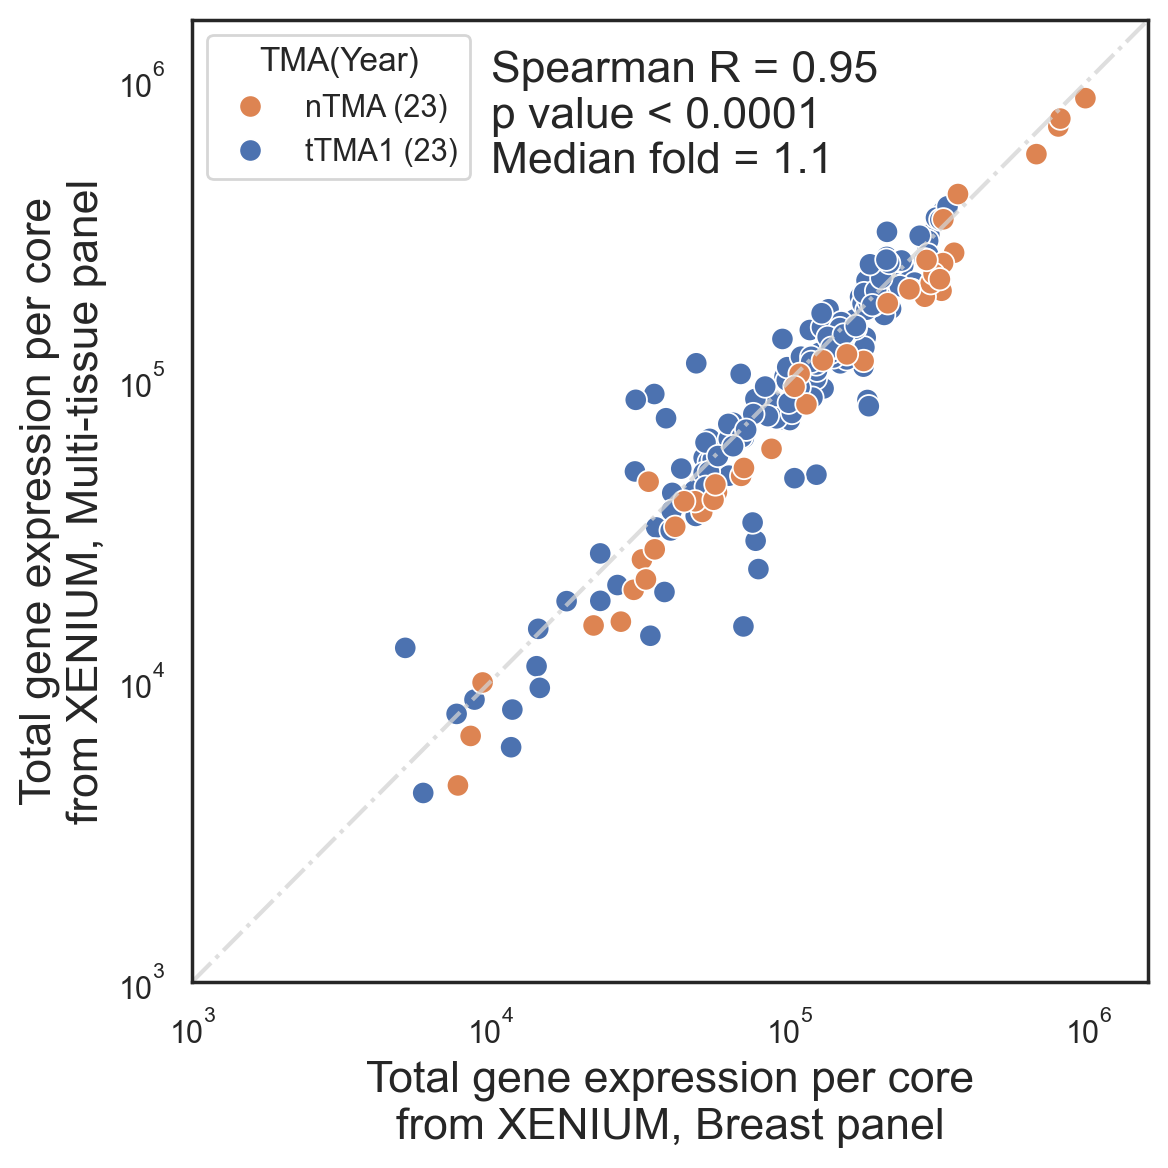

Xenium,breast vs. Xenium,lung


1.28

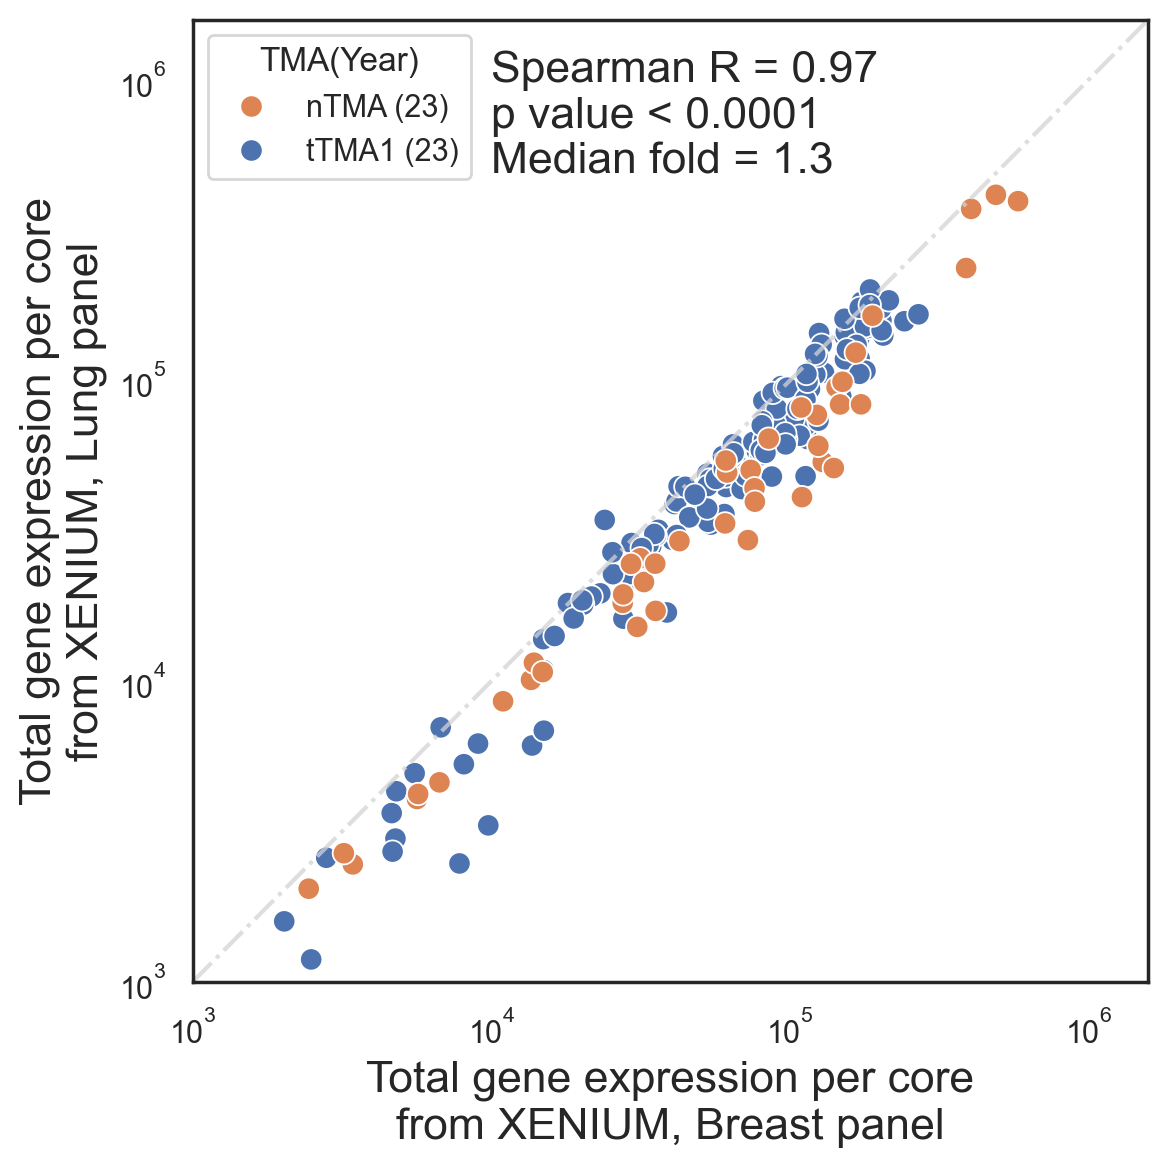

MERSCOPE,breast vs. MERSCOPE,lung


3.3

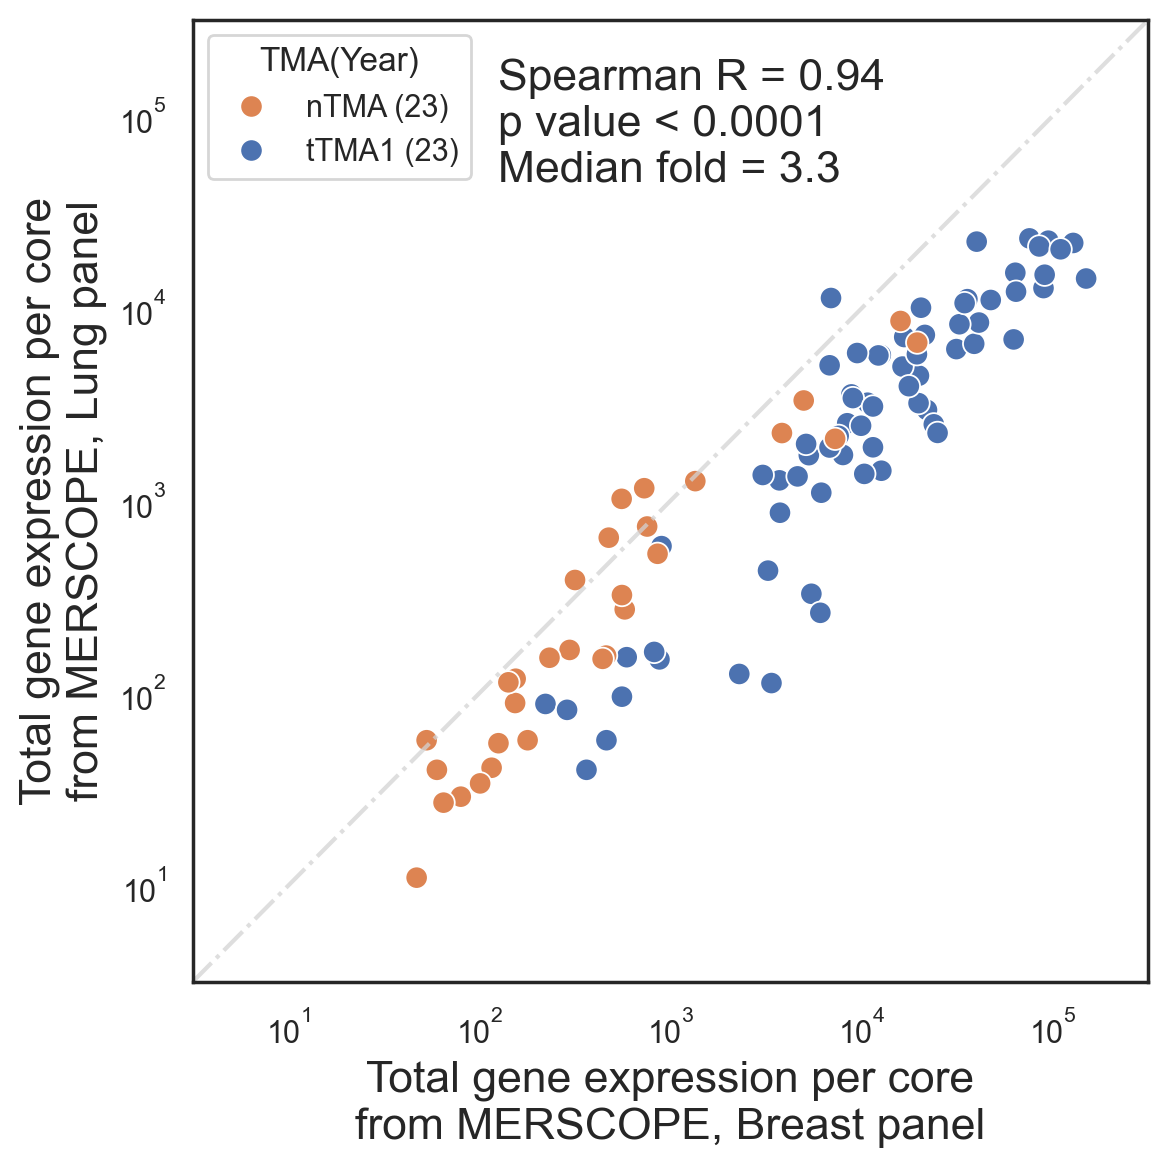

In [49]:


if not os.path.exists(f'{wd}/figures/Fig_1'):
    os.makedirs(f'{wd}/figures/Fig_1')

fontsize = 16

for Platform_Panel_pair in [
    (Platform_Panels[0], Platform_Panels[1]),  # panel to panel, xenium
    (Platform_Panels[0], Platform_Panels[2]),  # panel to panel, xenium
    (Platform_Panels[3], Platform_Panels[4])   # panel to panel, merscope
]:
    sample1 = Platform_Panel_pair[0]    
    df_1 = df_all[sample1].rename(columns={'count': sample1})
    df_1 = df_1.loc[df_1['code_type'] == 'gene'].drop('code_type', axis=1)

    sample2 = Platform_Panel_pair[1]
    df_2 = df_all[sample2].rename(columns={'count': sample2})
    df_2 = df_2.loc[df_2['code_type'] == 'gene'].drop('code_type', axis=1)

    print(f'{sample1} vs. {sample2}')

    common_genes = np.intersect1d(df_1.gene.unique(), df_2.gene.unique())
    df_1 = df_1.loc[df_1['gene'].isin(common_genes)]
    df_1 = df_1.groupby(['core', 'tissue_type']).agg({sample1: 'sum'}).reset_index()
    df_2 = df_2.loc[df_2['gene'].isin(common_genes)]
    df_2 = df_2.groupby(['core', 'tissue_type']).agg({sample2: 'sum'}).reset_index()

    df_both = pd.merge(df_1, df_2, on=['core', 'tissue_type'], how='inner')
    df_both = df_both.loc[~df_both['core'].isin([6, 24, 66, 74, 75, 212, 230, 238, 239, 240])] # 239 back
    df_both['fold'] = df_both.apply(lambda row: round(row[sample1] / row[sample2], 3), axis=1)
    m_fold = df_both['fold'].median()
    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)

    df_both.reset_index(inplace=True)
    df_both['Core source'] = df_both['core'].apply(lambda x: 'tTMA1 (23)' if int(x) < 200 else 'nTMA (23)')
    # df_both = df_both.loc[df_both['fold'] < 0.5]
    display(round(df_both['fold'].median(), 2))

    lims = [10**0.5, 10**5.5]
    if 'Xenium' in sample1 and 'Xenium' in sample2:
        lims = [10**3, 10**6.2]

    sns.set(style='white', rc={'figure.figsize': (6, 6), 'figure.dpi': 200})
    
    ax = sns.scatterplot(data=df_both, x=f"{sample1}", y=f"{sample2}", hue='Core source', alpha=1, s=65)
    plt.xlabel(f"Total gene expression per core\nfrom {sample1.split(',')[0].upper()}, {sample1.split(',')[1].capitalize()} panel", fontsize=fontsize)
    plt.ylabel(f"Total gene expression per core\nfrom {sample2.split(',')[0].upper()}, {sample2.split(',')[1].capitalize()} panel", fontsize=fontsize)

    plt.plot(lims, lims, color='#D3D3D3', linestyle='-.', alpha=0.75)
    r, p = sp.stats.spearmanr(df_both[f"{sample1}"], df_both[f"{sample2}"])
    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"


    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(lims[0], lims[1])
    plt.ylim(lims[0], lims[1])

    # Sorting the legend
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = handles[1:-3] + handles[-2:], labels[1:-3] + labels[-2:]
    sorted_labels, sorted_handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(sorted_handles, sorted_labels, title='TMA(Year)', loc='upper left')

    annotation_text = f"Spearman R = {round(r, 2)}\np value {p_text}\nMedian fold = {m_fold}"
    if 'Xenium' in sample1 and 'Xenium' in sample2:
        plt.text(10**4, 10**6.1, annotation_text, fontsize=fontsize, verticalalignment='top')
    else:
        plt.text(10**2.1, 10**5.3, annotation_text, fontsize=fontsize, verticalalignment='top')

    plt.tight_layout()
    plt.savefig(f'{wd}/figures/reproducibility/excluding_unmatched_cores_reproducibity_{sample1}_vs_{sample2}.png', bbox_inches='tight',transparent=True)
    # plt.savefig(f'{wd}/figures/reproducibility/excluding_unmatched_cores_reproducibity_{sample1}_vs_{sample2}.eps', bbox_inches='tight',transparent=True)
    plt.show()


# MERSCOPE: Round 1 breast vs. round 2 breast 

sample: merscope_breast_htma
sample: merscope_breast_normal
sample: merscope_breast_htma_round1
sample: merscope_breast_normal_round1
sample: merscope_lung_htma
sample: merscope_lung_normal
MERSCOPE,breast(10µm) vs. MERSCOPE,breast(5µm)


3.35

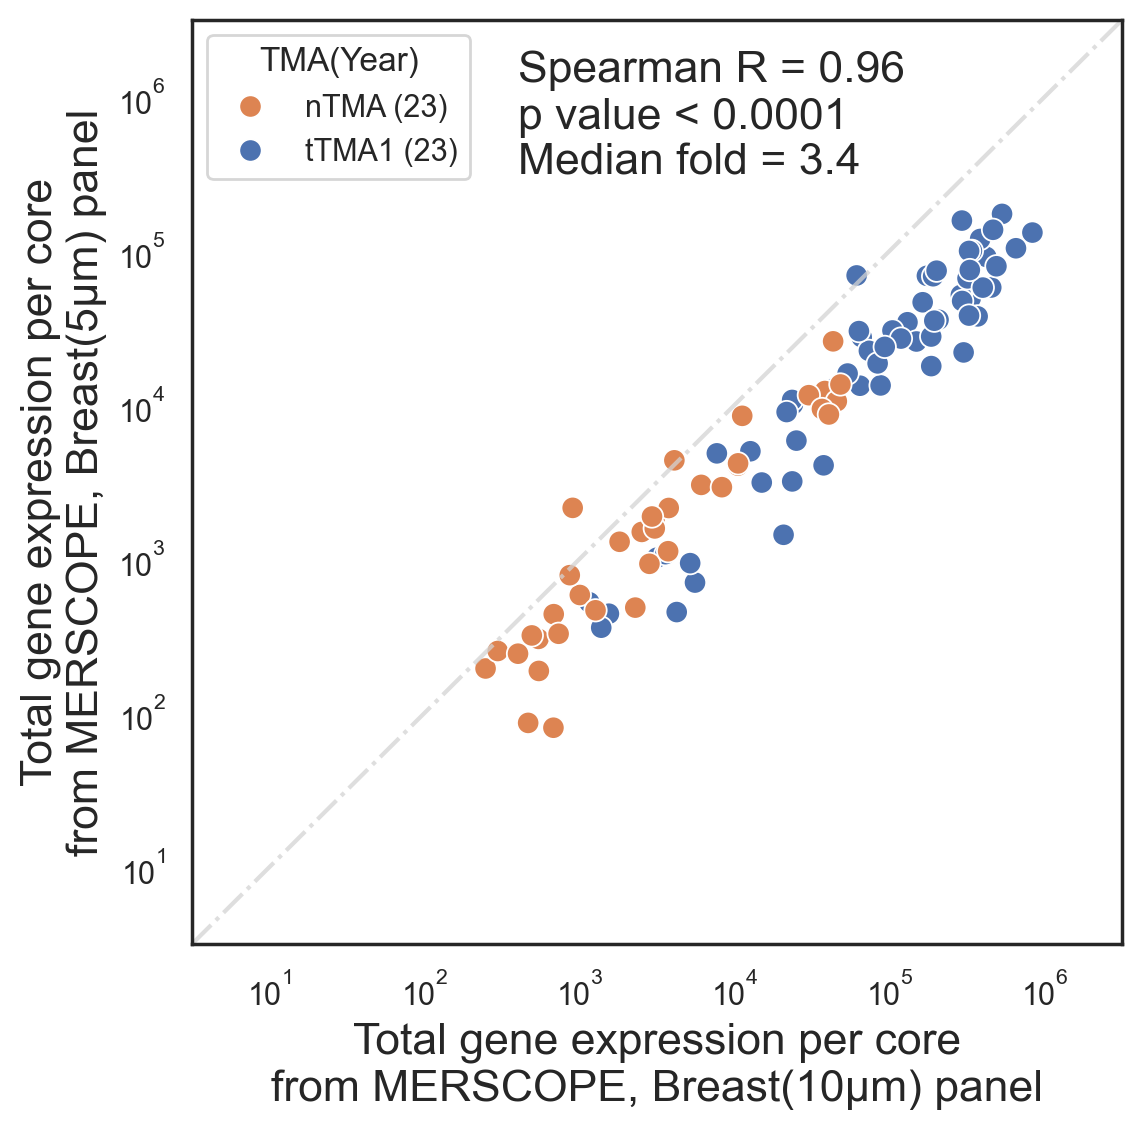

MERSCOPE,breast(5µm) vs. MERSCOPE,lung(5µm)


1.09

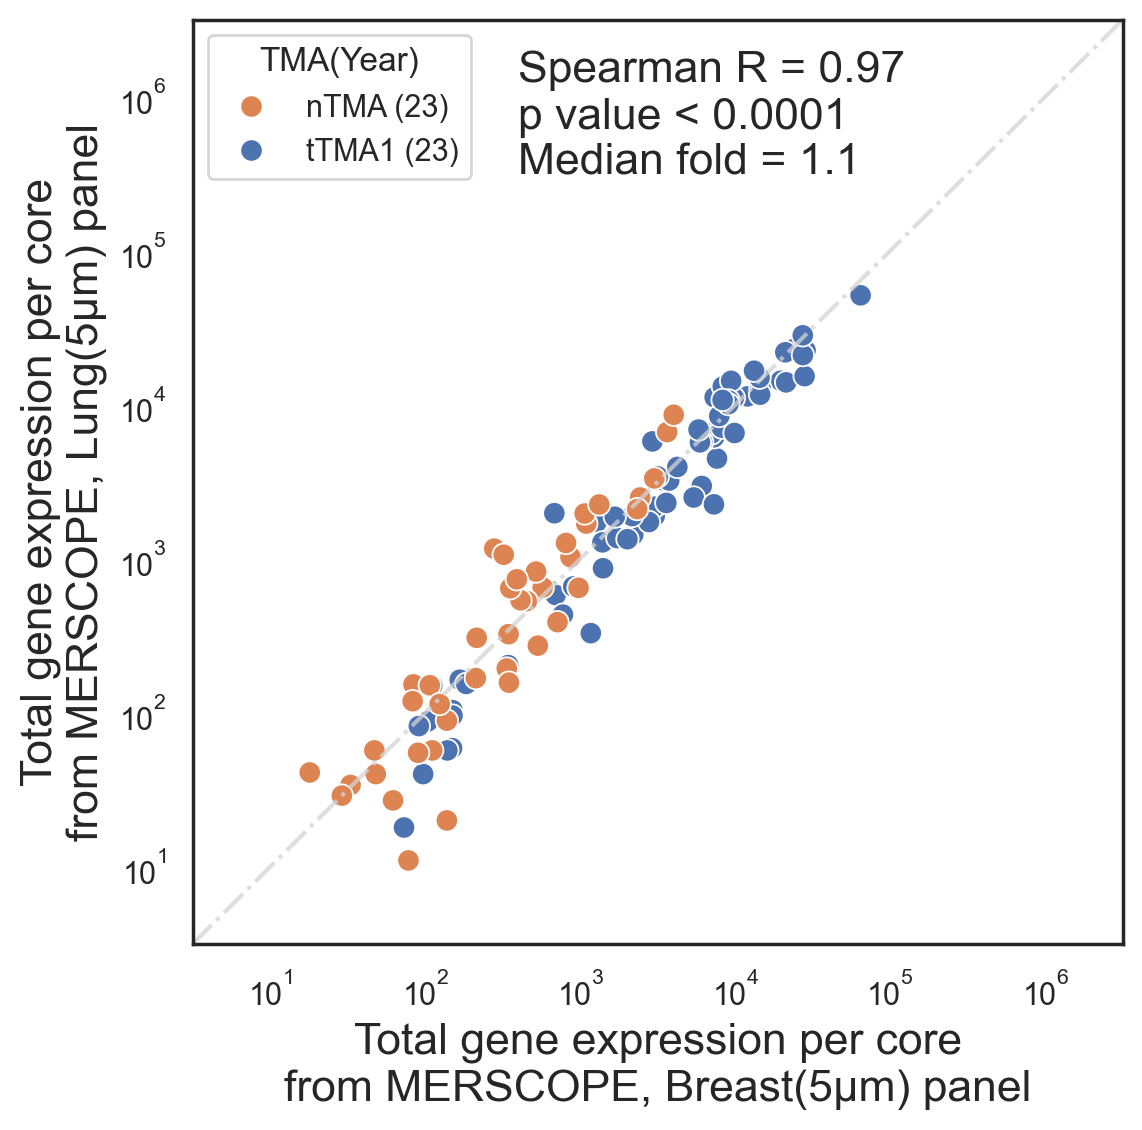

MERSCOPE,breast(10µm) vs. MERSCOPE,lung(5µm)


3.25

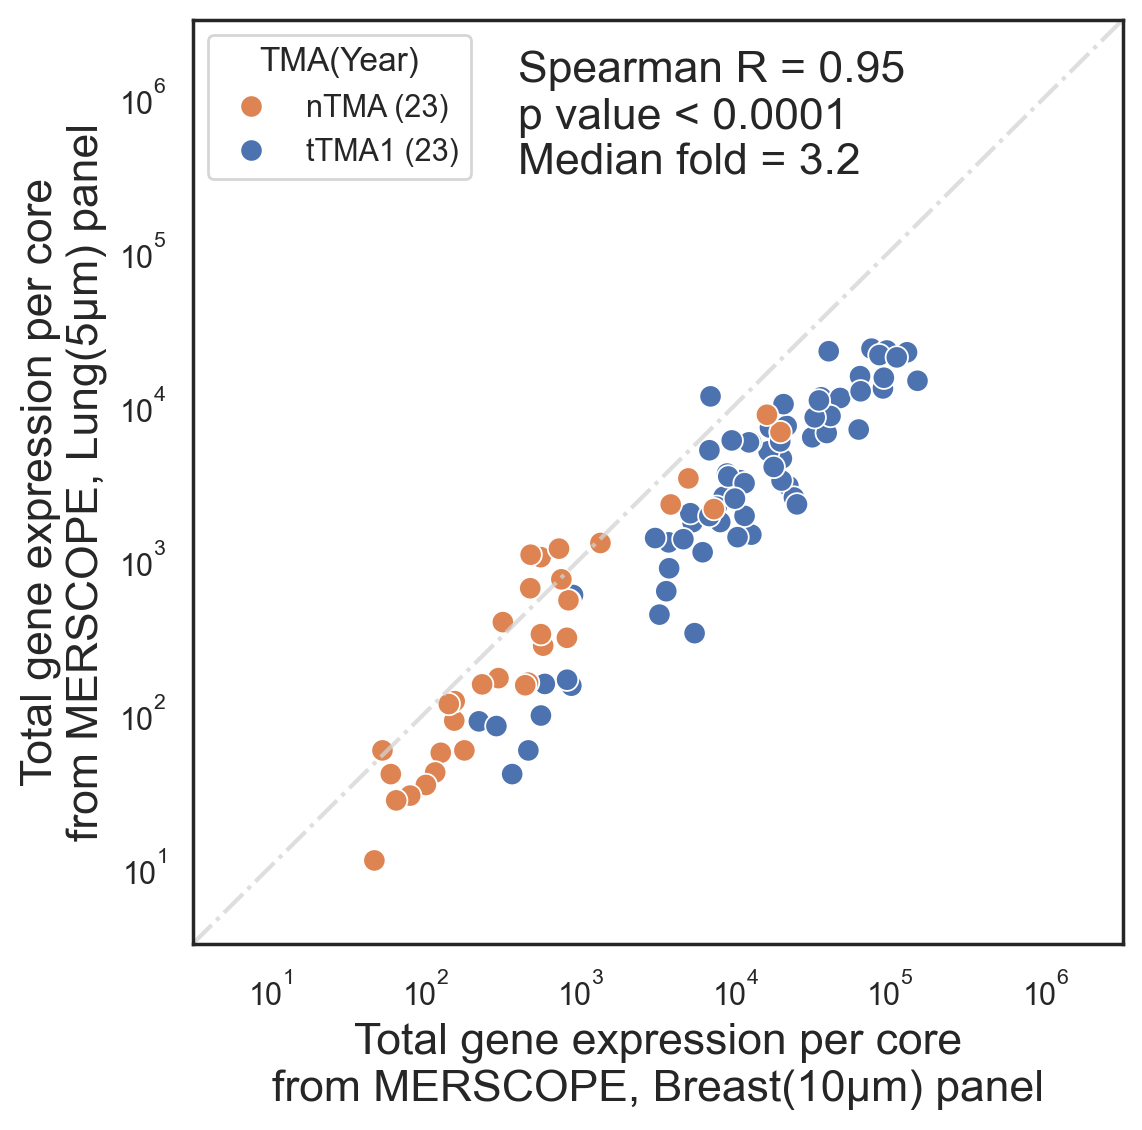

In [50]:
df_t_all = {}

samples = ['merscope_breast_htma',
            'merscope_breast_normal',
            'merscope_breast_htma_round1',
            'merscope_breast_normal_round1',
            'merscope_lung_htma',
            'merscope_lung_normal']

for sample in samples:
    print (f'sample: {sample}')
    df_t, df_core, gene_list = load(sample)
    df_t_all[sample] = df_t

df_all = {}

Platform_Panels =  ['MERSCOPE,breast(10µm)',
                    'MERSCOPE,breast(5µm)',
                    'MERSCOPE,lung(5µm)',
                    ]

for i in range(0,3):
    df_all[Platform_Panels[i]] = pd.DataFrame()
    df_htma = df_t_all[samples[2*i]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_htma])
    df_normal = df_t_all[samples[2*i+1]].copy()
    df_all[Platform_Panels[i]] = pd.concat([df_all[Platform_Panels[i]], df_normal])


for Platform_Panel_pair in [(Platform_Panels[0],Platform_Panels[1]),
                            (Platform_Panels[1],Platform_Panels[2]),
                            (Platform_Panels[0],Platform_Panels[2])]:

    sample1 = Platform_Panel_pair[0]    
    df_1 = df_all[sample1].rename(columns={'count':sample1})
    df_1 = df_1.loc[df_1['code_type']=='gene'].drop('code_type', axis=1)

    sample2 = Platform_Panel_pair[1]
    df_2 = df_all[sample2].rename(columns={'count':sample2})
    df_2 = df_2.loc[df_2['code_type']=='gene'].drop('code_type', axis=1)

    print (f'{sample1} vs. {sample2}')

    common_genes = np.intersect1d(df_1.gene.unique(),df_2.gene.unique())
    df_1 = df_1.loc[df_1['gene'].isin(common_genes)]
    df_1 = df_1.groupby(['core', 'tissue_type']).agg({sample1:'sum'}).reset_index()
    df_2 = df_2.loc[df_2['gene'].isin(common_genes)]
    df_2 = df_2.groupby(['core', 'tissue_type']).agg({sample2:'sum'}).reset_index()

    df_both = pd.merge(df_1, df_2, on=['core', 'tissue_type'], how='inner')
    df_both = df_both.loc[~df_both['core'].isin([74, 75, 76, 118, 58, 116, 212, 213, 238])] # 239 back
    df_both['fold'] = df_both.apply(lambda row: round(row[sample1] / row[sample2], 3), axis=1)
    m_fold = df_both['fold'].median()
    if m_fold < 0.05:
        m_fold = round(m_fold, 2)
    else:
        m_fold = round(m_fold, 1)

    df_both.reset_index(inplace=True)
    df_both['Core source'] = df_both['core'].apply(lambda x: 'tTMA1 (23)' if int(x) < 200 else 'nTMA (23)')

    display(round(df_both['fold'].median(), 2))

    lims = [10**0.5, 10**6.5]

    sns.set(style='white', rc={'figure.figsize': (6, 6), 'figure.dpi': 200})
    
    ax = sns.scatterplot(data=df_both, x=f"{sample1}", y=f"{sample2}", hue='Core source', alpha=1, s=65)
    plt.xlabel(f"Total gene expression per core\nfrom {sample1.split(',')[0].upper()}, {sample1.split(',')[1].capitalize()} panel", fontsize=fontsize)
    plt.ylabel(f"Total gene expression per core\nfrom {sample2.split(',')[0].upper()}, {sample2.split(',')[1].capitalize()} panel", fontsize=fontsize)

    plt.plot(lims, lims, color='#D3D3D3', linestyle='-.', alpha=0.75)
    r, p = sp.stats.spearmanr(df_both[f"{sample1}"], df_both[f"{sample2}"])
    p_text = '< 0.0001' if p < 0.0001 else f"= {round(p, 7)}"

    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(lims[0], lims[1])
    plt.ylim(lims[0], lims[1])

    # Sorting the legend
    handles, labels = ax.get_legend_handles_labels()
    handles, labels = handles[1:-3] + handles[-2:], labels[1:-3] + labels[-2:]
    sorted_labels, sorted_handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(sorted_handles, sorted_labels, title='TMA(Year)', loc='upper left')

    annotation_text = f"Spearman R = {round(r, 2)}\np value {p_text}\nMedian fold = {m_fold}"
    plt.text(10**2.6, 10**6.3, annotation_text, fontsize=fontsize, verticalalignment='top')

    # for idx, row in df_both.iterrows():
    #         plt.text(row[sample1], row[sample2], str(row['core']), fontsize=8, ha='right')


    plt.savefig(f'{wd}/figures/reproducibility/excluding_unmatched_cores_reproducibity_{sample1}_vs_{sample2}.png', bbox_inches='tight',transparent=True)
    # plt.savefig(f'{wd}/figures/reproducibility/excluding_unmatched_cores_reproducibity_{sample1}_vs_{sample2}.eps', bbox_inches='tight',transparent=True)
    plt.show()